#### **Import dependencies**


In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import os

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import random

!pip install -q kaggle
!pip install -q kaggle-cli

print(tf.__version__)

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "<your_kaggle_username>" 
os.environ['KAGGLE_KEY'] = "<your_kaggle_key>"

!kaggle datasets download -d nstiwari/hindi-character-recognition --unzip

#### **Convert JPG images into NPZ (NumPy array) format**
#### The Hindi character images are already converted into their corresponding NPZ format. These files are available in the dataset (HindiCharacterRecognition directory) you just downloaded in the above cell. Hence, you don't need to convert them again. 



#### Run this cell only if you wish to work on a custom data of your choice (OR) run this cell if you wish to see how images are converted into a NumPy array.

In [3]:
path_to_files = "/content/HindiCharacterRecognition/raw_images/10/" # Converts all the images inside HindiCharacterRecognition/raw_images/10 folder into a NumPy array.
vectorized_images = []

for _, file in enumerate(os.listdir(path_to_files)):
  image = Image.open(path_to_files + file)
  image_array = np.array(image)
  vectorized_images.append(image_array)

np.savez("./10.npz", DataX=vectorized_images)

#### **Load the training images NumPy array**

In [4]:
path = "./HindiCharacterRecognition/vectorized_images/numeral_images.npz"
with np.load(path) as data:
    #load DataX as train_data
    train_images = data['DataX']

#### **Load the training labels NumPy array**

In [5]:
path = "./HindiCharacterRecognition/vectorized_labels/numeral_labels.npz"
with np.load(path) as data:
    #load DataX as train_data
    train_labels = data['DataX']

In [23]:
NO_OF_CLASSES = 10  # Change the no. of classes according to your custom dataset

#### **Normalize the input images**

In [ ]:
# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images / 255.0
print('Pixels are normalized.')

#### **Inspect the shape of image and label arrays**
#### • The shape of the images array should be (X, 28, 28) where X = no. of images.
#### • The shape of the labels array should be (X, )

**Note:** The no. of images and no. of labels should be equal.

In [ ]:
train_images.shape

In [ ]:
train_labels.shape

#### **Visualize the training data**

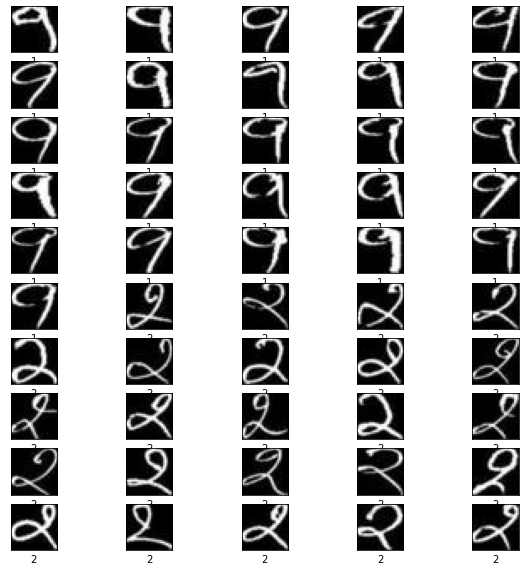

In [32]:
# Show the first 25 images in the training dataset.
j=0
plt.figure(figsize=(10,10))
for i in range(550, 600):    # Try playing with different ranges in interval of 50. Example: range(250, 300)
  j=j+1
  plt.subplot(10,5,j)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[i], cmap=plt.cm.gray)
  plt.xlabel(train_labels[i])
plt.show()

### **Start Model Training**

In [ ]:
# Define the model architecture
model = keras.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28)),
  keras.layers.Reshape(target_shape=(28, 28, 1)),
  keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=tf.nn.relu),
  keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=tf.nn.relu),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Dropout(0.25),
  keras.layers.Flatten(),
  keras.layers.Dense(NO_OF_CLASSES)  
])

# Define how to train the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the digit classification model
model.fit(train_images, train_labels, epochs=50)

In [ ]:
model.summary()

#### **Convert the TF model into the TensorFlow Lite format**

In [ ]:
# Convert Keras model to TF Lite format.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_float_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_float_model)
# Show model size in KBs.
float_model_size = len(tflite_float_model) / 1024
print('Float model size = %dKBs.' % float_model_size)

In [ ]:
# Re-convert the model to TF Lite using quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Show model size in KBs.
quantized_model_size = len(tflite_quantized_model) / 1024
print('Quantized model size = %dKBs,' % quantized_model_size)
print('which is about %d%% of the float model size.'\
      % (quantized_model_size * 100 / float_model_size))

In [ ]:
# Save the quantized model to file to the Downloads directory
f = open('mnist.tflite', "wb")
f.write(tflite_quantized_model)
f.close()

# Download the digit classification model
from google.colab import files
files.download('mnist.tflite')

print('`mnist.tflite` has been downloaded')